The code consists of the following parts:

1. **Section 1** - Prepare datasets
2. **Section 2** - Modelling
3. **Section 3** - Fine-tuning
4. **Section 4** - Evaluation

In [24]:
# Load Libraries & Dataset
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
from utils import merge_data
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, roc_curve, auc

data_path = '/Volumes/WORK/dataset/retail_project/cleaned_data/cleaned_data.csv'
products_data_path = '/Volumes/WORK/dataset/retail_project/cleaned_data/potential_products.csv'

## Section 1: Prepare datasets

In [27]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:  # 9, 10, 11
        return 'autumn'


def grouped_data(df, group_col, value_col, group_type):
    grouped_df = df.groupby(group_col).agg({value_col: group_type}).reset_index()
    return grouped_df

def categorize(row, ox, oy):
    if row[ox] == 5 and 4 <= row[oy] <= 5:
        return 'Champions'
    elif 3 <= row[ox] <= 4 and 4 <= row[oy] <= 5:
        return 'Loyal Customer'
    elif 4 <= row[ox] <= 5 and 2 <= row[oy] <= 3:
        return 'Potential Loyalist'
    elif row[ox] == 5 and row[oy] == 1:
        return 'New Customers'
    elif row[ox] == 4 and row[oy] == 1:
        return 'Promising'
    elif row[ox] == 3 and 1 <= row[oy] <= 2:
        return 'Needs Attention'
    elif row[ox] == 3 and row[oy] == 3:
        return 'About to Sleep'
    elif 1 <= row[ox] <= 2 and row[oy] == 5:
        return 'Can\'t Loose Them'
    elif 1 <= row[ox] <= 2 and 3 <= row[oy] <= 4:
        return 'At Risk'
    elif 1 <= row[ox] <= 2 and 1 <= row[oy] <= 2:
        return 'Hibernating'
    else:
        return 'Unclassified'


def segment_customers_rfm(df):
    # df['invoice_date'] = pd.to_datetime(df['invoice_date'])
    reference_date = df['invoice_date'].max() + pd.Timedelta(days=1)

    # Calculate R,F,M
    rfm = df.groupby('customer_id').agg({
        'invoice_date': lambda x: (reference_date - x.max()).days,  # Recency
        'invoice': 'nunique',                                       # Frequency
        'revenue': 'sum'                                            # Monetary
    }).reset_index()

    rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']
    rfm['recency_score'] = pd.qcut(rfm['recency'], 5, labels=[5,4,3,2,1])
    rfm['monetary_score'] = pd.qcut(rfm['monetary'], 5, labels=[1,2,3,4,5])

    rfm['segment_customers'] = rfm.apply(categorize, axis=1, args=('recency_score', 'monetary_score'))
    return rfm



def created_feature_engineering(data):
    df = data.copy()
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])
    ####### Feature engineering
    df_feat_eng = df[['customer_id','label']].drop_duplicates()

    ###  1. Number of Invoices per Customer (num_invoices)
    # Compute groupby aggregations
    invoices_df = grouped_data(df[df['invoice_type']=='purchase'], 'customer_id', 'invoice', 'nunique')
    invoices_df = invoices_df.rename(columns={'invoice': 'num_invoice'})
    # Merge with feature engineering data
    df_feat_eng = merge_data(df_feat_eng, invoices_df[['customer_id','num_invoice']], 'customer_id', 'customer_id', None, 'left')

    ####  2. Average Revenue per Invoice per Customer (avg_invoice_revenue)
    # Compute groupby aggregations
    revenue_per_invoice = grouped_data(df, ['customer_id', 'invoice'], 'revenue', 'sum')
    avg_invoice_revenue =  revenue_per_invoice.groupby('customer_id').agg(avg_invoice_revenue = ('revenue', 'mean')).reset_index()
    # Merge with feature engineering data
    df_feat_eng = merge_data(df_feat_eng, avg_invoice_revenue[['customer_id','avg_invoice_revenue']], 'customer_id', 'customer_id', None, 'left')

    ####  3. Average Purchase Interval per Customer (avg_purchase_interval)
    # Compute groupby aggregations
    invoice_dates = df[df['invoice_type']=='purchase'][['customer_id', 'invoice_date']].drop_duplicates(keep='first')
    invoice_dates['invoice_date'] = pd.to_datetime(invoice_dates['invoice_date'])
    invoice_dates = invoice_dates.sort_values(by=['customer_id', 'invoice_date'])
    invoice_dates['purchase_interval'] = invoice_dates.groupby('customer_id')['invoice_date'].diff().dt.days
    avg_purchase_interval = grouped_data(invoice_dates, 'customer_id', 'purchase_interval', 'mean')
    avg_purchase_interval = avg_purchase_interval.rename(columns={'purchase_interval': 'avg_purchase_interval'})
    # Merge with feature engineering data
    df_feat_eng = merge_data(df_feat_eng, avg_purchase_interval[['customer_id','avg_purchase_interval']], 'customer_id', 'customer_id', None, 'left')
    # df_feat_eng['avg_purchase_interval'] = df_feat_eng['avg_purchase_interval'].fillna(1000)

    ####  4. Average Product Price per Customer (avg_price)
    # Compute groupby aggregations
    stock_code_price_per_customer = df[df['invoice_type']=='purchase'][['customer_id', 'invoice_date','price']].sort_values('invoice_date', ascending=False)
    stock_code_price_per_customer = stock_code_price_per_customer.drop_duplicates(subset='customer_id', keep='first').reset_index(drop=True)
    avg_price = grouped_data(stock_code_price_per_customer, 'customer_id', 'price', 'mean')
    avg_price = avg_price.rename(columns={'price': 'avg_price'})
    # Merge with feature engineering data
    df_feat_eng = merge_data(df_feat_eng, avg_price[['customer_id','avg_price']], 'customer_id', 'customer_id', None, 'left')

    ####  5. Number of Product Types per Customer (num_product_types)
    # Compute groupby aggregations
    num_product_types = grouped_data(df[df['invoice_type']=='purchase'], 'customer_id', 'stock_code', 'nunique')
    num_product_types = num_product_types.rename(columns={'stock_code': 'num_product_types'})
    # Merge with feature engineering data
    df_feat_eng = merge_data(df_feat_eng, num_product_types[['customer_id','num_product_types']], 'customer_id', 'customer_id', None, 'left')

    ####  6. Revenue per Customer (revenue)
    # Compute groupby aggregations
    revenue = grouped_data(df, 'customer_id', 'revenue', 'sum')
    # Merge with feature engineering data
    df_feat_eng = merge_data(df_feat_eng, revenue[['customer_id','revenue']], 'customer_id', 'customer_id', None, 'left')

    ### 7. Top10 products purchase count (top10_products_purchase_count)
    # Compute groupby aggregations
    top10_products_purchase_count = grouped_data(df[df['potential_products']==1], 'customer_id', 'quantity', 'sum')
    top10_products_purchase_count = top10_products_purchase_count.rename(columns={'quantity': 'top10_products_purchase_count'})
    # Merge with feature engineering data
    df_feat_eng = merge_data(df_feat_eng, top10_products_purchase_count[['customer_id','top10_products_purchase_count']], 'customer_id', 'customer_id', None, 'left')
    df_feat_eng['top10_products_purchase_count'] = df_feat_eng['top10_products_purchase_count'].fillna(0)

    #### 8. Recency top10 purchase days (recency_top10_purchase_days)
    last_top10_purchase_date = df[df['potential_products']==1].groupby('customer_id').agg(last_top10_purchase_date = ('invoice_date', 'max')).reset_index()
    reference_date = df['invoice_date'].max() + pd.Timedelta(days=1)
    last_top10_purchase_date['recency_top10_purchase_days'] = (
        reference_date - last_top10_purchase_date['last_top10_purchase_date']
    ).dt.days
    # Merge with feature engineering data
    df_feat_eng = merge_data(df_feat_eng, last_top10_purchase_date[['customer_id','recency_top10_purchase_days']], 'customer_id', 'customer_id', None, 'left')
    df_feat_eng['recency_top10_purchase_days'] = df_feat_eng['recency_top10_purchase_days'].fillna(1000)


    #### 9. Revenue top10
    df_2010 = df[['customer_id','num_invoice_autumn']].drop_duplicates()
    # Merge with feature engineering data
    df_feat_eng = merge_data(df_feat_eng, df_2010, 'customer_id', 'customer_id', None, 'left')
    df_feat_eng['num_invoice_autumn'] = df_feat_eng['num_invoice_autumn'].fillna(0)

    # #### 10. Revenue trend (revenue_trend)
    # df_sorted = data.sort_values(by=['customer_id', 'invoice_date'])
    # first_revenue = data.groupby('customer_id').first()['revenue']
    # last_revenue = data.groupby('customer_id').last()['revenue']
    # revenue_trend = last_revenue - first_revenue
    # trend_df = revenue_trend.reset_index().rename(columns={'revenue': 'revenue_trend'})
    # # Merge with feature engineering data
    # df_feat_eng = merge_data(df_feat_eng, trend_df[['customer_id','revenue_trend']], 'customer_id', 'customer_id', None, 'left')
    return df_feat_eng


def created_dataset(min_time, max_time, data):
    #### Get months
    months = data[(data['month']<=max_time)&(data['month']>=min_time)]['month'].unique()

    #### Split dataset
    # Feature data
    feature_df =  data[data['month'].isin(sorted(months, reverse=False)[:5])].copy()
    feature_customers = feature_df['customer_id'].unique()

    # Labled data
    labeled_data = data[
        (data['month'].isin(sorted(months, reverse=False)[5:7])) &
        (data['potential_products']==1) &
        (data['customer_id'].isin(feature_customers))
    ]

    # Assign label
    return_customers =  labeled_data[labeled_data['invoice_type']=='purchase']['customer_id'].unique()
    feature_df['label'] = np.where(feature_df['customer_id'].isin(return_customers),1,0)

    #### Created feature engineering
    x_data =  created_feature_engineering(feature_df)

    #### Segment customers rfm
    segment_customers = segment_customers_rfm(feature_df)
    x_data = merge_data(x_data, segment_customers[['customer_id','segment_customers']], 'customer_id', 'customer_id', None, 'left')

    return x_data

In [29]:
#### Load data

# Potential products
potential_products_df = pd.read_csv(products_data_path)

# Transaction data
data = pd.read_csv(data_path)
data['invoice_date'] = pd.to_datetime(data['invoice_date'])
data['potential_products'] = np.where(data['stock_code'].isin(potential_products_df['stock_code'].unique()),1,0)

# Extract data in 2010
df_2010 = data[data['invoice_date'].dt.year == 2010].reset_index(drop=True)
df_2010['season'] = df_2010['month'].apply(get_season)
df_2010['num_invoice_autumn'] = (df_2010[df_2010['season'] == 'autumn'].groupby('customer_id')['invoice'].transform('nunique'))
df_2010 = df_2010[['customer_id','num_invoice_autumn']].drop_duplicates()

# Merge feature in 2010
data = merge_data(data, df_2010, 'customer_id', 'customer_id', None, 'left')

# Split dataset:
test_dataset = created_dataset('2011-05', '2011-11', data)
validation_dataset = created_dataset('2011-03', '2011-09', data)
train_dataset = created_dataset('2011-01', '2011-07', data)


In [30]:
# Normalize data

scaler = StandardScaler()
cols_to_scale = test_dataset.columns[2:-1]
# scaler.fit_transform(pd.concat([train_dataset[cols_to_scale], validation_dataset[cols_to_scale], test_dataset[cols_to_scale]]))
scaler.fit_transform(train_dataset[cols_to_scale])
train_dataset[cols_to_scale] = scaler.transform(train_dataset[cols_to_scale])
validation_dataset[cols_to_scale] = scaler.transform(validation_dataset[cols_to_scale])
test_dataset[cols_to_scale] = scaler.transform(test_dataset[cols_to_scale])

## Section 2: Modelling

In [32]:
def prepare_dmatrix(df, label_col):
    X = df.drop(columns=[label_col, 'segment_customers'])
    y = df[label_col]
    return xgb.DMatrix(X, label=y)

def train_model(params, dtrain, num_boost_round, dvalid=None, early_stopping_rounds=10):
    if dvalid is not None:
        evals = [(dtrain, 'train'), (dvalid, 'eval')]
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=early_stopping_rounds,
            verbose_eval=False
        )
    else:
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            verbose_eval=False
        )
    return model

def predict(model, dmatrix, threshold=0.5):
    y_pred_prob = model.predict(dmatrix)
    y_pred = (y_pred_prob >= threshold).astype(int)
    return y_pred_prob, y_pred

def evaluate(y_true, y_pred, y_pred_prob):
    precision = precision_score(y_true, y_pred)
    return precision

def feature_importance(model, importance_type='weight', top_n=10):
    importance = model.get_score(importance_type=importance_type)
    sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    return sorted_importance

In [33]:
# Declaration params
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'error',
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    # 'scale_pos_weight': 1.8,
    'seed': 42,
    'verbosity': 0
}

label_col = 'label'

# Prepare DMatrix
dtrain = prepare_dmatrix(train_dataset, label_col)
dvalid = prepare_dmatrix(validation_dataset, label_col)

# Train model
model = train_model(params, dtrain, 40, dvalid, 5)
# Predict test
y_val_true = validation_dataset[label_col]
y_pred_prob, y_pred = predict(model, dvalid, threshold=0.5)

# Evaluation
precision = evaluate(y_val_true, y_pred, y_pred_prob)

print(f"Validation Precision: {precision:.4f}")

Validation Precision: 0.7078


In [34]:
print(model.attributes())

{'best_iteration': '17', 'best_score': '0.19191148416634873'}


## Section 3: Fine-tuning

In [47]:
results = []

tree_counts = [10, 20, 30, 40]
max_depths = list(range(3, 11))

for nt in tree_counts:
    for md in max_depths:
        params_loop = params.copy()
        params_loop['max_depth'] = md
        dtrain = prepare_dmatrix(train_dataset, 'label')
        dvalid = prepare_dmatrix(validation_dataset, 'label')
        model_loop = train_model(params_loop, dtrain, nt, dvalid, 5)
        y_prob, y_pred = predict(model_loop, dvalid)
        precision  = evaluate(validation_dataset['label'], y_pred, y_prob)
        results.append({'num_trees': nt, 'max_depth': md, 'precision': precision})

tree_depth_df = pd.DataFrame(results)

In [48]:
best_tree = tree_depth_df[tree_depth_df['precision']==tree_depth_df['precision'].max()]['num_trees'].tolist()[0]
best_max_depth = tree_depth_df[tree_depth_df['precision']==tree_depth_df['precision'].max()]['max_depth'].tolist()[0]

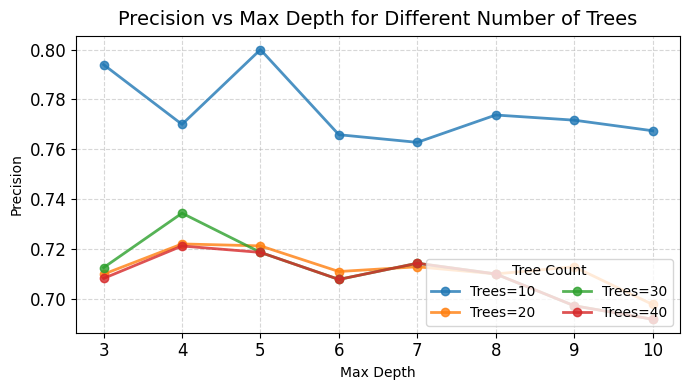

In [49]:
plt.figure(figsize=(7, 4))
for i, nt in enumerate(tree_counts):
    subset = tree_depth_df[tree_depth_df['num_trees'] == nt]
    plt.plot(
        subset['max_depth'],
        subset['precision'],
        label=f'Trees={nt}',
        linewidth=2,
        marker='o',
        markersize=6,
        linestyle='-',
        alpha=0.8
    )

plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Max Depth', fontsize=10)
plt.ylabel('Precision', fontsize=10)
plt.title('Precision vs Max Depth for Different Number of Trees', fontsize=14, pad=8)
plt.xticks(range(3, 11), fontsize=12)
plt.yticks(fontsize=12)
# plt.ylim(0.72, 0.85)
plt.legend(title='Tree Count', fontsize=10, title_fontsize=10, loc='lower right', ncol=2)
plt.tight_layout()
plt.show()

In [50]:
results = []
lr_list = list(np.arange(0.1, 1.1, 0.1))
for lr in lr_list:
    params_loop = params.copy()
    params_loop['max_depth'] = best_max_depth
    params_loop['eta'] = lr
    dtrain = prepare_dmatrix(train_dataset, 'label')
    dvalid = prepare_dmatrix(validation_dataset, 'label')
    model_loop = train_model(params_loop, dtrain, best_tree, dvalid, early_stopping_rounds=5)
    y_prob, y_pred = predict(model_loop, dvalid)
    precision = evaluate(validation_dataset['label'], y_pred, y_prob)
    results.append({'lr': lr, 'precision': precision})

lr_df = pd.DataFrame(results)
best_lr = lr_df[lr_df['precision'] == lr_df['precision'].max()]['lr'].tolist()[0]
print(f'Best lr: {best_lr}')

Best lr: 0.1


In [55]:
lr_df

,lr,precision
0,0.1,0.800000
1,0.2,0.689024
2,0.3,0.666667
3,0.4,0.639896
4,0.5,0.628647
5,0.6,0.640097
6,0.7,0.611765
7,0.8,0.615566
8,0.9,0.563679
9,1.0,0.575949


## Section 4: Evaluation

In [58]:
best_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'error',
    'eta': best_lr,
    'max_depth': best_max_depth,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    # 'scale_pos_weight': 1.8,
    'seed': 42,
    'verbosity': 0
}
dtest = prepare_dmatrix(test_dataset, 'label')
best_model = train_model(params, dtrain, best_tree, None, 5)
y_prob, y_pred = predict(best_model, dtest)

## Section 4: Evaluation

In [61]:
def random_customers(num, num_iteration, data):
    results = []
    for i in range(0,num_iteration):
        random_df = data.sample(n=num, replace=False)

        value = random_df[random_df['label']==1]['customer_id'].nunique()/random_df['customer_id'].nunique()
        results.append(value)

    return sum(results) / len(results)

### 4.1: Features important

In [66]:
sorted_importance= feature_importance(model, importance_type='weight', top_n=10)

print("\nFeature importances:")
for feature, score in sorted_importance[:20]:
    print(f"{feature}: {score}")



Feature importances:
avg_invoice_revenue: 119.0
revenue: 112.0
avg_purchase_interval: 110.0
avg_price: 108.0
recency_top10_purchase_days: 108.0
customer_id: 107.0
num_product_types: 96.0
num_invoice_autumn: 85.0
top10_products_purchase_count: 80.0
num_invoice: 25.0


### 4.2: Segment customers rfm

In [69]:
# Predict test dataset
dtest  = prepare_dmatrix(test_dataset, 'label')
y_test_true = test_dataset['label']
y_pred_prob, y_pred = predict(model, dtest, threshold=0.5)
test_dataset['pred_prob'] = y_pred_prob

# Evaluation
precision= evaluate(y_test_true, y_pred, y_pred_prob)

In [71]:
# RFM top customers
rfm_top_customers =  test_dataset[test_dataset['segment_customers'].isin(["Champions","Loyal Customer","Can\'t Loose Them"])]
num_compared_customers = rfm_top_customers['customer_id'].nunique()
rfm_top_label1_ratio = rfm_top_customers[rfm_top_customers['label']==1]['customer_id'].nunique()/num_compared_customers
print(f'RFM top label1 ratios = {rfm_top_label1_ratio}')

# Model top customers
model_top_customers = test_dataset.sort_values(by='pred_prob',ascending=False).head(num_compared_customers)
model_top_label1_ratio = model_top_customers[model_top_customers['label']==1]['customer_id'].nunique()/num_compared_customers
print(f'Model top label1 ratios = {model_top_label1_ratio}')

# Random customer
print(f'Random customers = {random_customers(num_compared_customers, 100,test_dataset)}')

RFM top label1 ratios = 0.3989473684210526
Model top label1 ratios = 0.4726315789473684
Random customers = 0.25675789473684213


### 4.3: Segment customers rfm detail:

In [78]:
# Champions
rfm_top_customers =  test_dataset[test_dataset['segment_customers'].isin(["Champions"])]
num_compared_customers = rfm_top_customers['customer_id'].nunique()
rfm_top_label1_ratio = rfm_top_customers[rfm_top_customers['label']==1]['customer_id'].nunique()/num_compared_customers
print(f'RFM top label1 ratios = {rfm_top_label1_ratio}')

# Model top customers
model_top_customers = test_dataset.sort_values(by='pred_prob',ascending=False).head(num_compared_customers)
model_top_label1_ratio = model_top_customers[model_top_customers['label']==1]['customer_id'].nunique()/num_compared_customers
print(f'Model top label1 ratios = {model_top_label1_ratio}')

# Random customer
print(f'Random customers = {random_customers(num_compared_customers, 100,test_dataset)}')

RFM top label1 ratios = 0.4473684210526316
Model top label1 ratios = 0.6695906432748538
Random customers = 0.2593567251461988


In [80]:
# RFM top customers
rfm_top_customers =  test_dataset[test_dataset['segment_customers'].isin(["Loyal Customer"])]
num_compared_customers = rfm_top_customers['customer_id'].nunique()
rfm_top_label1_ratio = rfm_top_customers[rfm_top_customers['label']==1]['customer_id'].nunique()/num_compared_customers
print(f'RFM top label1 ratios = {rfm_top_label1_ratio}')

# Model top customers
model_top_customers = test_dataset.sort_values(by='pred_prob',ascending=False).head(num_compared_customers)
model_top_label1_ratio = model_top_customers[model_top_customers['label']==1]['customer_id'].nunique()/num_compared_customers
print(f'Model top label1 ratios = {model_top_label1_ratio}')

# Random customer
print(f'Random customers = {random_customers(num_compared_customers, 100,test_dataset)}')

RFM top label1 ratios = 0.38404452690166974
Model top label1 ratios = 0.5825602968460112
Random customers = 0.2601669758812616


In [84]:
# RFM top customers
rfm_top_customers =  test_dataset[test_dataset['segment_customers'].isin(["Can\'t Loose Them"])]
num_compared_customers = rfm_top_customers['customer_id'].nunique()
rfm_top_label1_ratio = rfm_top_customers[rfm_top_customers['label']==1]['customer_id'].nunique()/num_compared_customers
print(f'RFM top label1 ratios = {rfm_top_label1_ratio}')

# Model top customers
model_top_customers = test_dataset.sort_values(by='pred_prob',ascending=False).head(num_compared_customers)
model_top_label1_ratio = model_top_customers[model_top_customers['label']==1]['customer_id'].nunique()/num_compared_customers
print(f'Model top label1 ratios = {model_top_label1_ratio}')

# Random customer
print(f'Random customers = {random_customers(num_compared_customers, 100,test_dataset)}')

RFM top label1 ratios = 0.2753623188405797
Model top label1 ratios = 0.8115942028985508
Random customers = 0.2628985507246377
